In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.ticker import FixedLocator

plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')

Using TensorFlow backend.


In [7]:
def set_plot_params():
    """Set global style parameters for plots"""
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.tight_layout()

In [8]:
def f(x):
    """Returns valuese of the ground truth function"""
    peak1 = 2
    peak2 = 4
    width1 = 0.3
    width2 = 0.1
    f1 = np.exp(-(x-peak1)**2 / (2*width1))
    f2 = np.exp(-(x-peak2)**2 / (2*width2))
    f = 0.2*f1 + 0.8 * f2
    return f

def p_0(x):
    """Returns the density of the training distribution"""
    return norm.pdf(x, loc=0, scale=1)

def p_t(x, mu, sig):
    """Returns the pdf of a Gaussian with given mean and std. dev."""
    return norm.pdf(x, loc=mu, scale=sig)

def p_greater(x, func=f, thresh=0.5, f_sig=0.1):
    """Returns P(Y>thresh|x)"""
    y = func(x)
    return norm.sf(thresh, loc=y, scale=f_sig)

def p_cond_prop(x, func=f, thresh=0.5, f_sig=0.1):
    """Returns the numerator of the posterior, i.e. P(Y>thresh|x)p_0(x)"""
    prop = p_0(x) * p_greater(x, func=func, thresh=thresh, f_sig=f_sig)
    return prop

def estimate_Z(p, func=f, thresh=0.5, f_sig=0.1, 
               n_mc=int(1e6), im_mean=1, im_width=1):
    """
    Estimates the partition function of the posteriror with 
    importance sampling
    """
    np.random.seed(1)
    im_samples = im_width * np.random.randn(n_mc) + im_mean
    Z = (1/n_mc) * np.sum(p_0(im_samples)/p_t(im_samples, im_mean, im_width) * p_greater(im_samples, func=func, thresh=thresh, f_sig=f_sig))
    return Z

def train_model(x_train, y_train, max_x = None, epochs=100, batch_size=10):
    """Trains a simple neural network on given data"""
    if max_x is not None:
        idxs = np.where(x_train < max_x)
        x_train = x_train[idxs]
        y_train = y_train[idxs]
    inp = Input(shape=(1,))
    h = Dense(50, activation='tanh')(inp)
    h = Dense(50, activation='tanh')(h)
    out = Dense(1)(h)
    model = Model(inputs=inp, outputs=out)
    
    model.compile(optimizer= 'adam',
                  loss='mse')
    model.fit(x_train, y_train,
             epochs=epochs,
             batch_size=batch_size,
             shuffle=True,
             verbose=2)
    return model

In [10]:
N = 1000
x = np.linspace(-3, 7, N)
y = f(x)

LOAD_MODELS=True
SAVE_MODELS=False

max_xs = [2, 6]
np.random.seed(1)
F_SIG = 0.05
y_train = y + np.random.randn(y.shape[0]) * F_SIG
models = {}
epochs = {2: 30, 6:90}
batch_size = {2:10, 6:10}

i = 0
for max_x in max_xs:
    if LOAD_MODELS:
        model= load_model('models/toy_model_dec_%i.h5' % max_x)
    else:
        model = train_model(x, y_train, max_x=max_x, epochs=epochs[max_x], batch_size=batch_size[max_x])
        if SAVE_MODELS:
            model.save('models/toy_model_dec_%i.h5' % max_x)
    models[max_x] = model

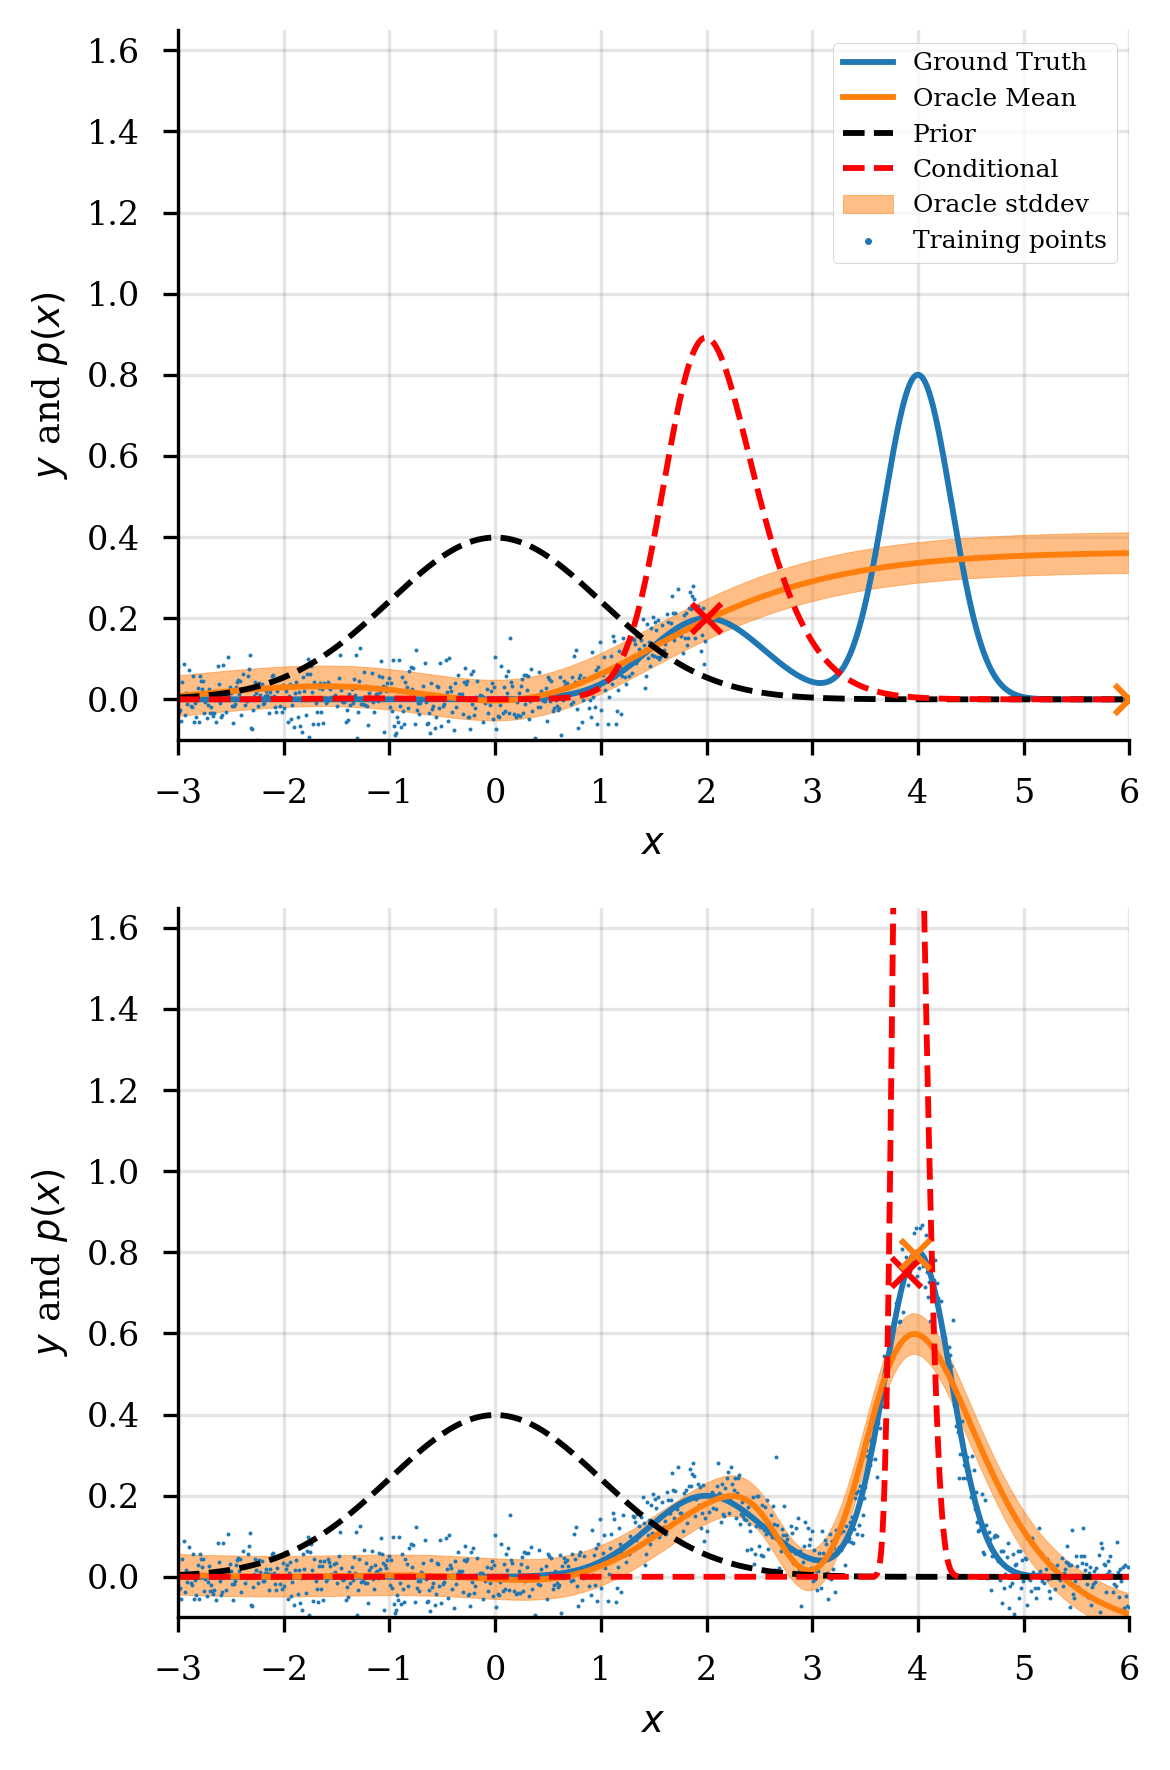

In [11]:
x_long = np.linspace(-3, 20, 10000)
fig, ax = plt.subplots(len(max_xs), 1, figsize=(4, 3*len(max_xs)))

ax = ax.flatten()
i = 0
for j in range(len(max_xs)):
    max_x = max_xs[j]
    x_range = np.linspace(-3, max_x, 1000)
    model = models[max_x]
    y_pred = model.predict(x_long)[:, 0]
    y_pred_range = model.predict(x_range)[:, 0]
    pred_sig=np.sqrt(np.mean((model.predict(x) - y_train)**2))
    pred_thresh=np.max(y_pred_range)
    def model_func(x):
        return model.predict(x)[:, 0]
    
    p_cond = p_cond_prop(x_long, func=model_func, thresh=pred_thresh, f_sig=F_SIG)
    dx = x_long[1] - x_long[0]
    Z = dx * np.sum(p_cond)
    fx_long = f(x_long)
    ax[i].plot(x_long, fx_long, label='Ground Truth', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    ax[i].plot(x_long, y_pred, label='Oracle Mean', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    ax[i].plot(x_long, p_0(x_long), label='Prior', c='k', ls='--')
    ax[i].plot(x_long, p_cond/Z, c='r', ls='--', label='Conditional' % pred_thresh)
    intervals = norm.interval(0.6827, loc=y_pred, scale=F_SIG)
    ax[i].fill_between(x_long, intervals[0], intervals[1], alpha=0.5, label="Oracle stddev", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    
    train_idxs = np.where(x < max_x )
    train_pts_y = y_train[train_idxs]
    train_pts_x = x[train_idxs]
    ax[i].scatter(train_pts_x, train_pts_y, s=2, alpha=1, marker='.', label='Training points')
    cond_mode_pos = x_long[np.argmax(p_cond)]
    cond_mode_gt = fx_long[np.argmax(p_cond)]
    
    plot_xrange = [-3, 6]
    
    max_plot_x_idx = np.max(np.where(x_long < plot_xrange[1]))
    max_oracle_pos = x_long[np.argmax(y_pred[:max_plot_x_idx])]
    max_oracle_gt = fx_long[np.argmax(y_pred[:max_plot_x_idx])]
    
    ax[i].scatter(cond_mode_pos, cond_mode_gt, s=50, marker='x', c='r', zorder=100)
    ax[i].scatter(max_oracle_pos, max_oracle_gt, s=50, marker='x', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], zorder=101)
    
    if i == 0:
        ax[i].legend(fontsize=6, markerscale=2)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$ and $p(x)$')
    
    ax[i].set_xlim([-3, 6])
    ax[i].set_ylim([-0.1, 1.65])

    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].grid(color='gray', alpha=0.2, which='major')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    i +=1 
plt.tight_layout()
# plt.show()
plt.savefig("plots/toy_setup_dec.png", dpi=500)
plt.show()
plt.close()

0 1 1 0 1 2.560812213647731
0 1 2 2.105490348328055 0.561835022036393 0.07653723899822229
0 1 3 2.0952456543905282 0.7056825404346908 0.14883659939381538
0 1 4 2.1302243843100146 0.7067310435680542 0.1506291451697675
0 1 5 2.162280015275778 0.6800939278352429 0.13715984664107952
0 1 6 2.07250271718633 0.634299289836003 0.10695237177781328
0 1 7 2.2144916857466797 0.7426661327092473 0.18628964691694247
0 1 8 2.0587382286327878 0.7068263734402475 0.15104282862553953
0 1 9 2.094481723939842 0.7239355157381421 0.1609681113851011
0 1 10 2.1736517257649495 0.6992937574012671 0.15069931869970973
0 1 11 2.100486885082425 0.7056993874594726 0.14885738436310647
0 1 12 2.1285612474336273 0.7032867253710928 0.14828167371761747
0 1 13 2.1189832510102993 0.7323354516292249 0.16711554250694544
0 1 14 2.0679427257515033 0.6836696520891115 0.1356627595679655
0 1 15 2.0727281049093675 0.6279572050031956 0.10367118676883773
0 1 16 2.0840877088531244 0.6417129224466204 0.11037410754195873
0 1 17 2.0794280

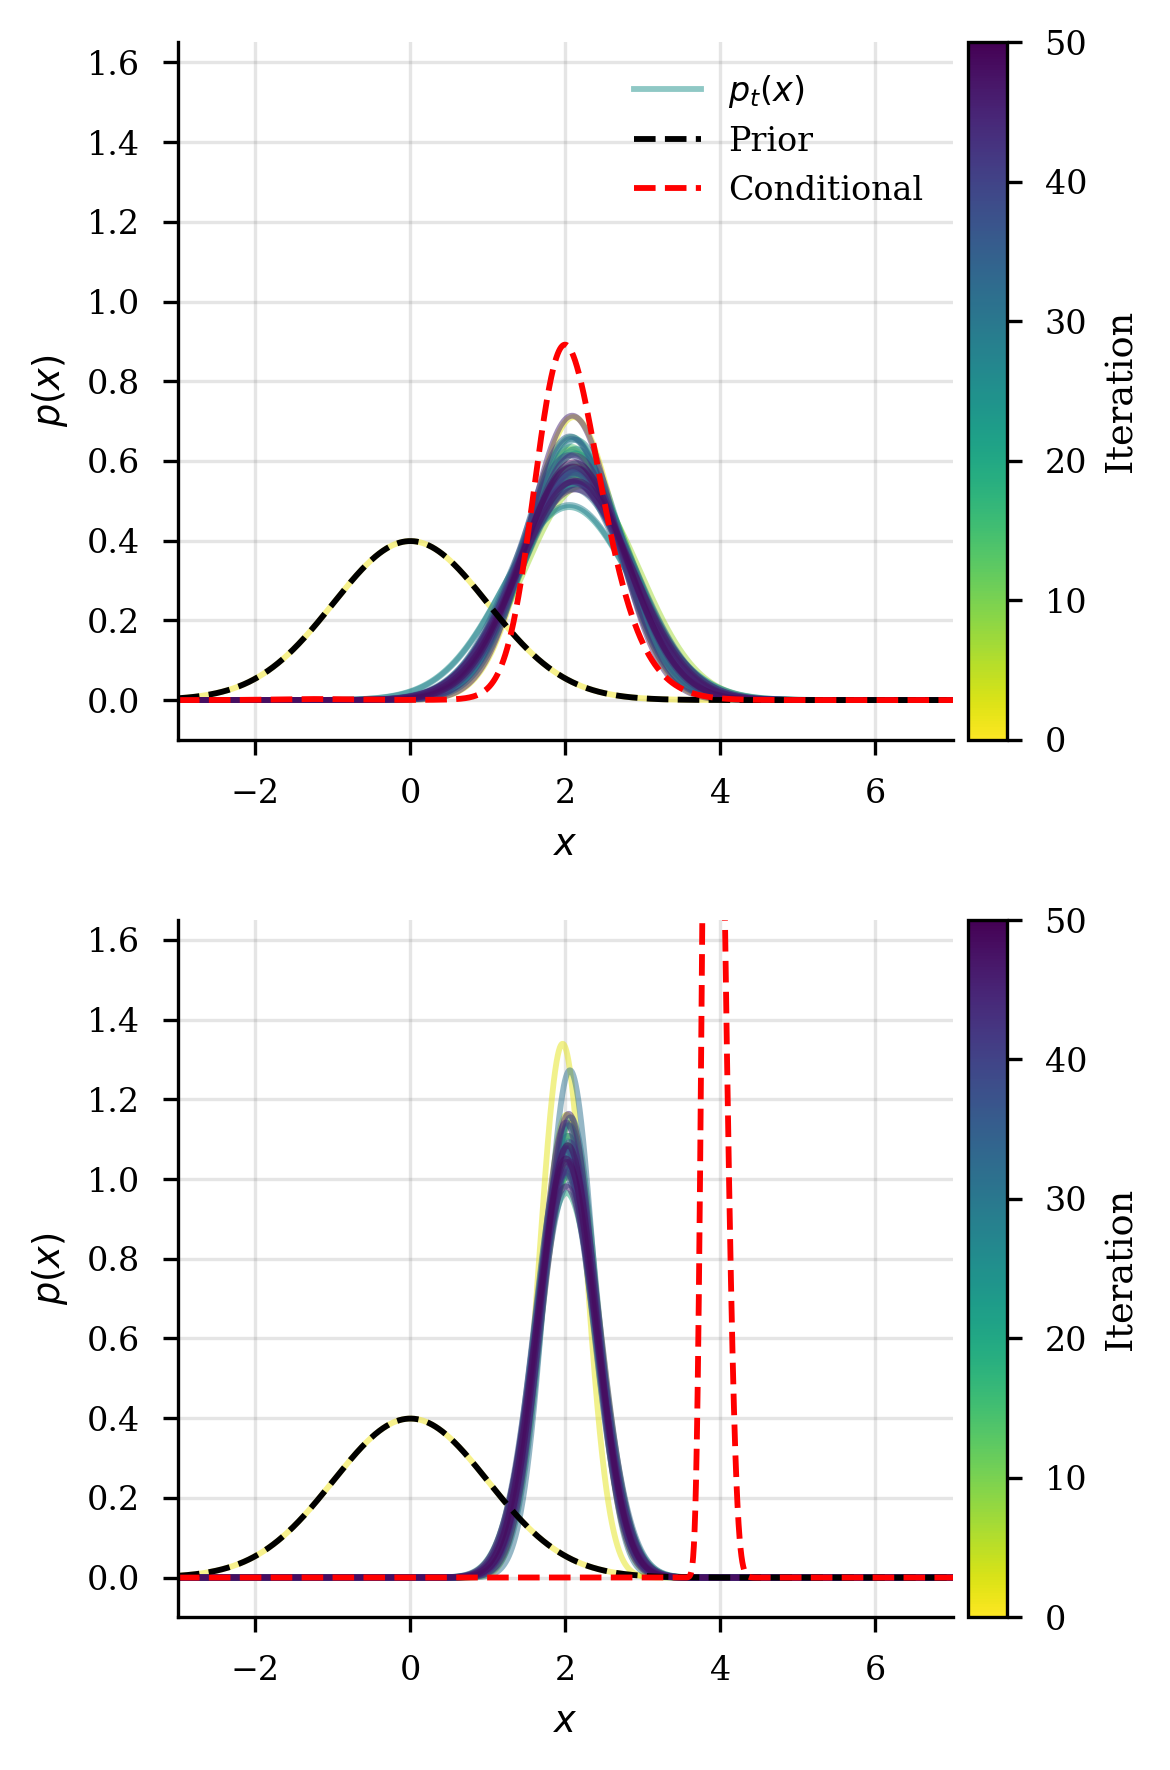

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

ax = ax.flatten()
i = 0
T = 50
mix_components = [1]
# model_idxs = [1, 5]
dkl = np.zeros((len(max_xs), len(mix_components), T+1))
for j in range(len(max_xs)):
    max_x = max_xs[j]
    x_range = np.linspace(-3, max_x, 1000)
    model = models[max_x]
    y_pred = model.predict(x_long)[:, 0]
    y_pred_range = model.predict(x_range)[:, 0]
#     pred_sig=np.sqrt(np.mean((model.predict(x) - y_train)**2))
    pred_thresh=np.max(y_pred_range)
    def model_func(x):
        return model.predict(x)[:, 0]
    
    p_cond = p_cond_prop(x_long, func=model_func, thresh=pred_thresh, f_sig=F_SIG)
    dx = x_long[1] - x_long[0]
    Z = dx * np.sum(p_cond)

    def calc_dkl_to_cond(p_vals):
        norm_cond = p_cond/Z
        idxs = np.where(p_vals != 0)
        vals = norm_cond[idxs] * np.log(norm_cond[idxs]) - norm_cond[idxs] * np.log(p_vals[idxs])
        dkl = dx * np.sum(vals)
        return dkl
    
    samples_per = 100
    for k in range(len(mix_components)):
        num_mix = mix_components[k]
        thresh_t = -np.inf
        thresh_quantile = 1
        if num_mix == 1:
            mu_t = 0
            sig_t = 1
            
            for t in range(1, T+1):
                x_t = sig_t * np.random.randn(samples_per) + mu_t
                y_t = model.predict(x_t)
                thresh_t_prime = np.percentile(y_t, thresh_quantile*100)
                if thresh_t_prime > pred_thresh:
                    thresh_t = pred_thresh
                elif thresh_t_prime > thresh_t:
                    thresh_t = thresh_t_prime
                p0_xt = p_0(x_t)
                pt_xt = p_t(x_t, mu_t, sig_t)
                pS_xt = p_greater(x_t, func=model_func, thresh=thresh_t, f_sig=F_SIG)
                w = (p0_xt / pt_xt) * pS_xt

                w_hat = np.sum(w)
                mu_new = np.sum(w*x_t) / w_hat
                sig_new = np.sqrt(2*np.sum(w*(x_t-mu_new)**2)/w_hat)
                
                pt_xlong = p_t(x_long, mu_t, sig_t)
                dkl[i, k, t] = calc_dkl_to_cond(pt_xlong)
                print(i, num_mix, t,mu_t, sig_t, dkl[i, k, t])
                
                mu_t = mu_new
                sig_t = sig_new
                
                
                if i == 1 or i==0:  # for second model, plot one mixture component
                    if t == int(T/2):
                        lbl = "$p_t(x)$"
                    else:
                        lbl=None
                        
                    ax[i].plot(x_long, pt_xlong, c=cm(t/(T+1)), alpha=0.5, label=lbl)
            if i == 1 or i == 0:    
                ax[i].plot(x_long, p_0(x_long), label='Prior', c='k', ls='--')
                ax[i].plot(x_long, p_cond/Z, c='r', ls='--', label='Conditional' % pred_thresh)

                ax[i].set_xlabel('$x$')
                ax[i].set_ylabel('$p(x)$')
                if i == 0:
                    ax[i].legend(frameon=False)
                ax[i].grid(True)
                ax[i].set_axisbelow(True)
                ax[i].grid(color='gray', alpha=0.2)

                ax[i].set_xlim([-3, 7])
                ax[i].set_ylim([-0.1, 1.65])
                ax[i].spines['right'].set_visible(False)
                ax[i].spines['top'].set_visible(False)
                
                # Only show ticks on the left and bottom spines
                ax[i].yaxis.set_ticks_position('left')
                ax[i].xaxis.set_ticks_position('bottom')

                c_norm = mpl.colors.Normalize(vmin=0, vmax=T)
                divider = make_axes_locatable(ax[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm,
                                                norm=c_norm,
                                                orientation='vertical')
                cb1.set_label('Iteration')
            
    i += 1
    
plt.tight_layout()
plt.savefig('plots/toy_traj_dec.png', dpi=500)
plt.show()

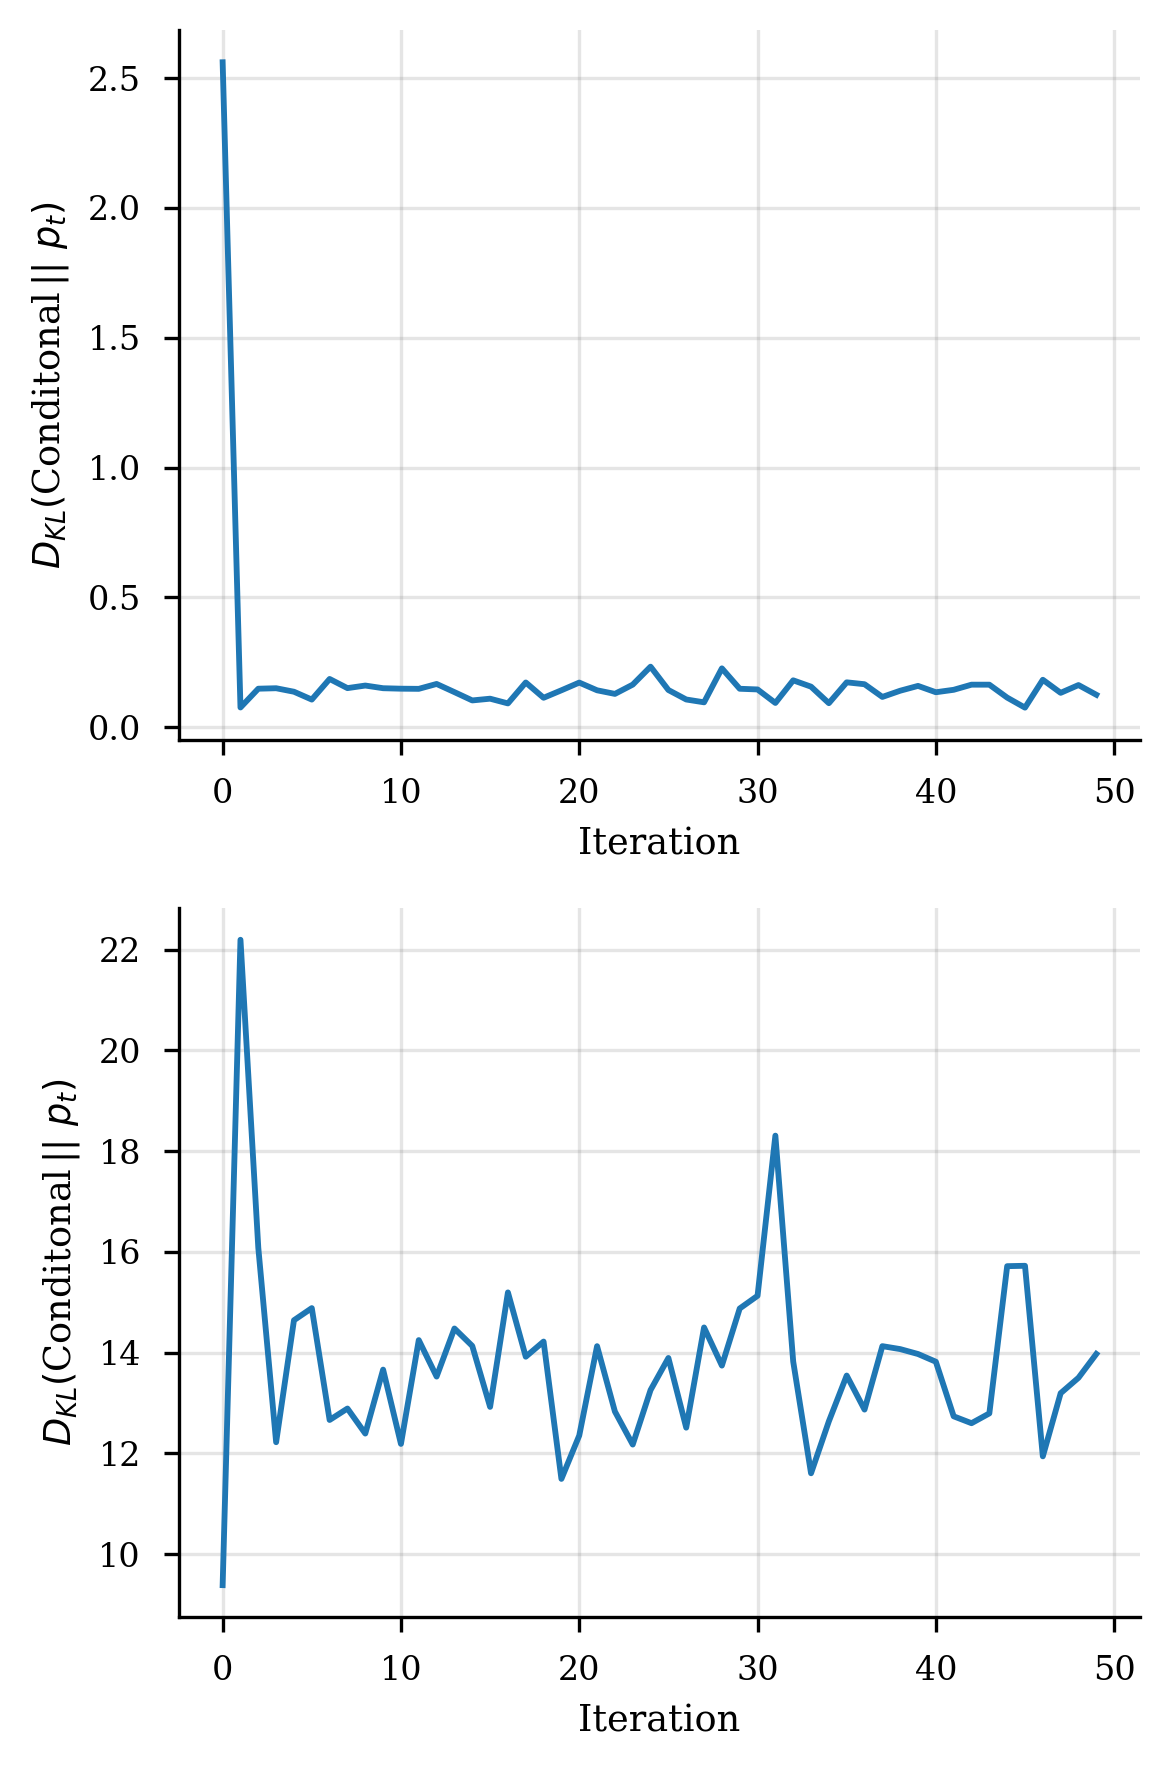

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))

ax = ax.flatten()
i = 0
T = 100
mix_components = [1]
model_idxs = [1, 5]
# dkl = np.zeros((len(model_idxs), len(mix_components), T+1))
i = 0
for j in [1, 5]:
    for k in range(len(mix_components)):
        dkls = dkl[i, k, 1:]
        ax[i].plot(range(len(dkls)), dkls)
    
    ax[i].set_xlabel("Iteration")
    ax[i].set_ylabel("$D_{KL}($Conditonal$ \\,||\\,\\,p_t)$")
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    ax[i].grid(color='gray', alpha=0.2)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
#     ax[i].set_ylim([0, np.max(dkls[i])])
    # Only show ticks on the left and bottom spines
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    i += 1
    
plt.tight_layout()
plt.savefig('plots/toy_dkl_dec.png', dpi=500)